## Riya Shyam Huddar  

Roll Number: MDS202431  
**NLP Assignment 1**


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Install wiki-dump-reader
!pip install wiki-dump-reader


  Preparing metadata (setup.py) ... done
  Created wheel for wiki-dump-reader: filename=wiki_dump_reader-0.0.4-py3-none-any.whl size=3981 sha256=346a994c426204b99ee49d56cc50973f752d21cb73416f2623a53c91bd7329fa
  Stored in directory: /root/.cache/pip/wheels/14/bf/c7/43b1a6ed31680fb90c2ba1397c49bf802dda63fd50417c502e
Successfully built wiki-dump-reader


In [4]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.5 MB/s eta 0:00:00


In [5]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 31.0 MB/s eta 0:00:00


In [7]:
!pip install stopwordsiso

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.6 MB/s eta 0:00:00


In [8]:
#Imports
import bz2
import re
import string
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import contractions
import stanza
import stopwordsiso as stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression


### Downloading the Wikipedia Dump  

To download the required Wikipedia dump directly into my Google Drive, I used the following command:

```bash
!wget -P /content/drive/MyDrive/NLP \
https://dumps.wikimedia.your.org/enwiki/20220520/enwiki-20220520-pages-articles-multistream9.xml-p2936261p4045402.bz2


### Decompressing the .bz2 file

In [ ]:
inputhi_bz2 = '/content/drive/MyDrive/NLP/hiwiki-latest-pages-articles.xml.bz2'
outputhi_xml = '/content/drive/MyDrive/NLP/hiwiki_full.xml'

# Decompress the .bz2 file
with bz2.open(inputhi_bz2, 'rb') as f_in, open(outputhi_xml, 'wb') as f_out:
    for chunk in iter(lambda: f_in.read(1024*1024), b''):  # read in 1 MB chunks
        f_out.write(chunk)

print("File saved as:", outputhi_xml)


File saved as: /content/drive/MyDrive/NLP/hiwiki_full.xml


In [ ]:
# Import modules
from wiki_dump_reader import Cleaner, iterate

# Writing corpus function
def write_corpus(dump_path, output_path):

    # Reads a Wikipedia XML dump, cleans each page, and writes
    # title + cleaned text to a file.

    page_count = 0
    cleaner = Cleaner()

    with open(output_path, 'w', encoding='utf-8') as output:
        for title, text in iterate(dump_path):
            # Clean the text
            text = cleaner.clean_text(text)
            cleaned_text, links = cleaner.build_links(text)


            output.write(title + '\n' + cleaned_text + '\n')

            # Print progress
            page_count += 1
            if page_count % 1000 == 0:
                print(f'Pages dumped = {page_count}', end='\r')

    print(f"\nFinished! Total pages processed: {page_count}")


In [ ]:
# Paths
dump_path = '/content/drive/MyDrive/NLP/enwiki_full.xml'
output_path = '/content/drive/MyDrive/NLP/enwiki_corpus.txt'  # final cleaned corpus


write_corpus(dump_path, output_path)

In [ ]:
# Paths
dumpmr_path = '/content/drive/MyDrive/NLP/mrwiki_full.xml'
outputmr_path = '/content/drive/MyDrive/NLP/mrwiki_corpus.txt'  # final cleaned corpus


write_corpus(dumpmr_path, outputmr_path)



Finished! Total pages processed: 182776


In [ ]:
# Paths
dumphi_path = '/content/drive/MyDrive/NLP/hiwiki_full.xml'
outputhi_path = '/content/drive/MyDrive/NLP/hiwiki_corpus.txt'  # final cleaned corpus


write_corpus(dumphi_path, outputhi_path)



Finished! Total pages processed: 239358


-------

## Preprocessing
**Overview:**  
The raw wikipedia data can contain a lot of noise, such as HTML tags, decorators and inconsistent casing. This pipeline cleans and normalizes the data by removing the noise while preserving meaningful tokens. The resulting cleaned corpus can then be used for further statistical analysis.
The aim of this preprocessing pipeline is to thus preserve the text true to the real language and making it clean and suitable for further statistical analysis.

### English

### Preprocessing Pipeline for English (Wikipedia Corpus)


#### 1. Line-Level Cleaning (`clean_english_line`)
Each line undergoes the following steps:

1. **Lowercasing and contraction expansion**  
   - Converts text to lowercase to ensure consistent casing and reduce redundant vocabulary tokens
   - Expands contractions (`don't-> do not`) which ensures accurate token mappings

2. **Removing metadata**  
   - Removes URLs (http://…, www.…).
   - Removes HTML-like tags and section headers (<…>, ==Header==).
   - Removes Wikipedia templates and metadata ({{…}}, start=…).

3. **Filtering Characters**  
   - Retains only letters, digits, whitespaces, hyphens and periods and removes everything else. Words like Covid-19, U.S.A, co-operate are preserved for accurate token mapping and words like ##deal are mapped as deal.
   - Combines multiple spaces as a single space and removes leading/trailing spaces

#### 2. Token-level Cleaning (`clean_english_token`)
- Strips leading/trailing hyphens or periods(`e.g.,--text-.->text`)
- Removes if any tokens are purely punctuations

#### 3. Token Validation (`is_valid_token_en`)
- Retains tokens containing at least one alphabetical character. Tokens like 123, ### are filtered out

#### 4. Corpus Processing (`preprocess_english_wikipedia`)
- Reads the corpus line by line and processes it
- Valid tokens are written to the output file

**Memory efficiency:**  
- Line by line processing ensures the scalability of the pipeline to a large corpora without loading the entire dataset into the memory



In [ ]:
# Download NLTK tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

def clean_english_line(line: str) -> str:
    # Lowercase + expand contractions
    line = line.lower()
    line = contractions.fix(line)

    # Remove URLs, HTML-like tags,section headers, metadata
    line = re.sub(r'http\S+|www\.\S+', ' ', line)
    line = re.sub(r'<.*?>', ' ', line)
    line = re.sub(r'\{\{.*?\}\}', ' ', line)
    line = re.sub(r'={2,}', ' ', line)
    line = re.sub(r'^start=.*', ' ', line)

    # Replace everything except letters, digits, whitespace, hyphen, and period with space
    line = re.sub(r'[^a-z0-9\s\.-]', ' ', line)


    line = re.sub(r'\s+', ' ', line).strip()
    return line

def clean_english_token(token: str) -> str:
    # Strip leading/trailing hyphens or periods
    token = token.strip('-.')

    # Drop empty or pure hyphen/period tokens
    if not token or re.fullmatch(r'[-.]+', token):
        return ''
    return token

def is_valid_token_en(token: str) -> bool:
    # Must contain at least one letter
    return bool(re.search(r'[a-z]', token))

def preprocess_english_wikipedia(input_path: str, output_path: str) -> Counter:
    word_counts = Counter()

    with open(input_path, 'r', encoding='utf-8') as f_in, \
         open(output_path, 'w', encoding='utf-8') as f_out:

        for line in f_in:
            line = clean_english_line(line)
            if not line:
                continue
            # tokenize
            tokens = word_tokenize(line)

            cleaned_tokens = []
            for t in tokens:
                t = clean_english_token(t)
                if t and not t.isdigit() and is_valid_token_en(t):
                    cleaned_tokens.append(t)

            if cleaned_tokens:
                word_counts.update(cleaned_tokens)
                f_out.write(" ".join(cleaned_tokens) + "\n")

    return word_counts

# Corpus paths
input_path_en = '/content/drive/MyDrive/NLP/enwiki_corpus.txt'
output_path_en = '/content/drive/MyDrive/NLP/enwiki_corpus_cleanedv2.txt'

word_counts_en = preprocess_english_wikipedia(input_path_en, output_path_en)

print("Top 20 words:", word_counts_en.most_common(20))
print(f"Cleaned corpus saved to: {output_path_en}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Top 20 words: [('the', 7867454), ('of', 3754919), ('in', 3222563), ('and', 3027381), ('a', 2260414), ('to', 2211517), ('was', 1278920), ('for', 908993), ('on', 887349), ('as', 886140), ('is', 869006), ('by', 781108), ('s', 746152), ('with', 739527), ('from', 622816), ('at', 595212), ('he', 589081), ('that', 561356), ('his', 485538), ('it', 457051)]
Cleaned corpus saved to: /content/drive/MyDrive/NLP/enwiki_corpus_cleanedv2.txt


In [9]:
from collections import Counter

# Helper function to re-compute only word counts from a clean file
def rebuild_word_counts(cleaned_path: str) -> Counter:
    word_counts = Counter()
    with open(cleaned_path, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.strip().split()
            word_counts.update(tokens)
    return word_counts


cleaned_path = '/content/drive/MyDrive/NLP/enwiki_corpus_cleanedv2.txt'
word_counts_en = rebuild_word_counts(cleaned_path)

print("Top 20 words:", word_counts_en.most_common(20))


Top 20 words: [('the', 7867454), ('of', 3754919), ('in', 3222563), ('and', 3027381), ('a', 2260414), ('to', 2211517), ('was', 1278920), ('for', 908993), ('on', 887349), ('as', 886140), ('is', 869006), ('by', 781108), ('s', 746152), ('with', 739527), ('from', 622816), ('at', 595212), ('he', 589081), ('that', 561356), ('his', 485538), ('it', 457051)]


In [ ]:
# Number of tokens in the cleaned English corpora
sum(word_counts_en.values())

114216313

### Marathi (Native Language)
### Preprocessing Pipeline for Marathi (Wikipedia Corpus)


#### 1. Cleaning Each Line (`clean_marathi_line`)
For every line in the corpus, we:
- **Remove section headers** like `==संदर्भ व नोंदी==`
- **Strip out content inside parantheses** such as citations, author info, or other metadata inside `( … )`.

#### 2. Cleaning and Validating Tokens (`is_valid_token_mr`)
Once a line is cleaned, we split it into tokens and:
- Keep tokens containing at least **one Devanagari character**, which filters out numbers, punctuation, and other irrelevant symbols.  
- Strip punctuation like `. , । “ ” ‘ ’ — –` from the start and end of each token.  


#### 3. Processing the Whole Corpus (`preprocess_marathi_wikipedia`)
- Reads the file **line by line** to handle large files.
- Applies the line cleaning and token validation steps to each line.    
- Writes the cleaned tokens to a new file so we can reuse it for further analysis.


In [ ]:
#Cleans a single line of Marathi Wikipedia text
def clean_marathi_line(line: str) -> str:


    # Remove full-line section headers like ==संदर्भ व नोंदी==
    line = re.sub(r'^=+.*=+$', '', line)

    # Remove parenthetical content (citations, author info)
    line = re.sub(r'\(.*?\)', '', line)

    return line.strip()

def is_valid_token_mr(token: str) -> bool:
  # Checks if a token is valid and contain at least one Devanagari character

    token = token.strip()
    if not token:
        return False
    return bool(re.search(r'[\u0900-\u097F]', token))

# Cleans Marathi Wikipedia text
def preprocess_marathi_wikipedia(input_path: str, output_path: str):

    word_counts = Counter()

    # Remove punctuation characters
    all_punct = string.punctuation + "।“”‘’—–"

    with open(input_path, 'r', encoding='utf-8') as f_in, \
         open(output_path, 'w', encoding='utf-8') as f_out:

        for line in f_in:
            line = clean_marathi_line(line)
            if not line:
                continue

            # Tokenize by spaces
            tokens = line.split()

            # Strip all punctuation and keep only valid tokens
            cleaned_tokens = []
            for t in tokens:
                t = t.translate(str.maketrans('', '', all_punct))
                if is_valid_token_mr(t):
                    cleaned_tokens.append(t)

            # Update word counts
            word_counts.update(cleaned_tokens)

            if cleaned_tokens:
                f_out.write(" ".join(cleaned_tokens) + "\n")

    return word_counts


input_path_mr = '/content/drive/MyDrive/NLP/mrwiki_corpus.txt'
output_path_mr = '/content/drive/MyDrive/NLP/mrwiki_corpus_cleaned.txt'

word_counts_mr = preprocess_marathi_wikipedia(input_path_mr, output_path_mr)

# Top 20 words
print("Top 20 words:", word_counts_mr.most_common(20))
print(f"Cleaned Marathi corpus saved to: {output_path_mr}")


Top 20 words: [('आणि', 261611), ('आहे', 260398), ('या', 149196), ('हे', 137596), ('व', 117352), ('एक', 101259), ('ते', 95852), ('हा', 88183), ('पुनर्निर्देशन', 77122), ('होते', 65846), ('आहेत', 64328), ('केले', 61309), ('ही', 59834), ('येथे', 58715), ('मध्ये', 54797), ('जिल्ह्यातील', 53862), ('तालुक्यातील', 49517), ('गावे', 49273), ('इस', 49190), ('केली', 48518)]
Cleaned Marathi corpus saved to: /content/drive/MyDrive/NLP/mrwiki_corpus_cleaned.txt


In [ ]:
# Number of Tokens in cleaned Marathi corpus
print(sum(word_counts_mr.values()))

15691225


### Hindi (Chosen Language)

### Preprocessing Pipeline for Hindi (Wikipedia Corpus)

#### 1. Cleaning Each Line (`clean_hindi_line`)
For every line in the corpus, we:
- **Remove section headers** like `==सन्दर्भ==` which are not part of actual content.  
- **Handle parentheses carefully**:  
  - Parenthetical content that contains any non-Devanagari characters (like English words, numbers, or punctuation) is **removed**.  
  - Parentheses containing only Hindi/Devanagari text are **kept**, preserving meaningful Hindi content.

This ensures that only relevant Hindi text is retained.

#### 2. Cleaning and Validating Tokens (`is_valid_token_hindi`)
Once a line is cleaned, we split it into tokens (words) and:
- Keep tokens that contain **at least one Devanagari character**, ensuring English, numbers, or irrelevant symbols are discarded.  
- Strip punctuation such as `. , । “ ” ‘ ’ — –` from the start and end of each token.  


#### 3. Processing the Whole Corpus (`preprocess_hindi_wikipedia`)
- Reads the file **line by line**, which allows us to efficiently process large files without running out of memory.  
- Applies line cleaning and token validation to each line.    
- Writes cleaned tokens to a new output file for further analysis.



In [ ]:
# Cleans a line of Hindi wikipedia text
def clean_hindi_line(line: str) -> str:

    # Remove full-line section headers like ==सन्दर्भ==
    line = re.sub(r'^=+.*=+$', '', line)

    # Remove parentheses that contain any non-Devanagari characters
    def paren_filter(match):
        content = match.group(1)
        if re.search(r'[^\u0900-\u097F\s]', content):  # contains non-Devanagari
            return ''  # remove this parenthetical
        else:
            return f'({content})'  # keep purely Hindi content

    line = re.sub(r'\((.*?)\)', paren_filter, line)

    return line.strip()

def is_valid_token_hindi(token: str) -> bool:
    # A valid token has atleast one Devnagari character
    token = token.strip()
    if not token:
        return False
    return bool(re.search(r'[\u0900-\u097F]', token))

def preprocess_hindi_wikipedia(input_path: str, output_path: str):
    # Cleans Hindi wikipedia text

    word_counts = Counter()

    # Remove punctuation characters
    all_punct = string.punctuation + "।“”‘’—–"

    with open(input_path, 'r', encoding='utf-8') as f_in, \
         open(output_path, 'w', encoding='utf-8') as f_out:

        for line in f_in:
            line = clean_hindi_line(line)
            if not line:
                continue

            # Tokenize by spaces
            tokens = line.split()

            # Strip all punctuation and keep only valid Hindi tokens
            cleaned_tokens = []
            for t in tokens:
                t = t.translate(str.maketrans('', '', all_punct))
                if is_valid_token_hindi(t):
                    cleaned_tokens.append(t)

            # Update word counts
            word_counts.update(cleaned_tokens)

            if cleaned_tokens:
                f_out.write(" ".join(cleaned_tokens) + "\n")

    return word_counts


input_path_hi = '/content/drive/MyDrive/NLP/hiwiki_corpus.txt'
output_path_hi = '/content/drive/MyDrive/NLP/hiwiki_corpus_cleaned.txt'

word_counts_hi = preprocess_hindi_wikipedia(input_path_hi, output_path_hi)

# Top 20 words
print("Top 20 Hindi words:", word_counts_hi.most_common(20))
print(f"Cleaned Hindi corpus saved to: {output_path_hi}")


Top 20 Hindi words: [('के', 4123680), ('में', 3209362), ('है', 2720141), ('की', 1953031), ('और', 1670233), ('से', 1635961), ('को', 1400418), ('का', 1310373), ('हैं', 1237217), ('एक', 902108), ('पर', 680815), ('किया', 594569), ('रूप', 560489), ('ने', 545344), ('लिए', 526014), ('गया', 499609), ('भी', 489821), ('यह', 483245), ('कि', 440366), ('था', 427711)]
Cleaned Hindi corpus saved to: /content/drive/MyDrive/NLP/hiwiki_corpus_cleaned.txt


--------

## Task 1: Zipf’s Law Analysis

We analyze the **rank-frequency distribution of words** in our cleaned corpora. For each language, we fit **both Zipf’s Law and Mandelbrot’s Law** to understand how well these models describe word frequencies.  

The parameters of both models $\alpha, \beta, C$ are **estimated using non-linear curve fitting** on the cleaned data.

---

### Zipf’s Law  

$$
f(r) = \frac{C}{r^\alpha}
$$

- $(f(r))$ = frequency of the word with rank \(r\)  
- $(C)$ = scaling constant (roughly the frequency of the most common word)  
- $(\alpha)$ = exponent controlling the rate at which frequency decreases with rank  

---

### Mandelbrot Law  

$$
f(r) = \frac{C}{(r + \beta)^\alpha}
$$

- $(\beta)$ = constant that adjusts the curve at top ranks  
- Other parameters are the same as Zipf’s Law  

---

All analyses and plots below are performed on the **cleaned corpora**, after preprocessing.

Below, we plot the **actual word frequencies** against both models on a **log–log scale** for each language.


In [14]:
# Function to plot Zipf's and Mandelbrot's curve + empirical curve
# Zipf model
def zipf(r, alpha, C):
    return C / (r ** alpha)

# Mandelbrot model
def mandelbrot(r, alpha, beta, C):
    return C / ((r + beta) ** alpha)

def plot_zipf_mandelbrot(word_counts: Counter, top_percent=0.05, title_suffix="Corpus"):
    # word_counts: Counter of token frequencies
    # Returns a dict with fitted parameters and metrics.

    # Prepare rank-frequency data
    words, freqs = zip(*word_counts.most_common())
    ranks = np.arange(1, len(freqs) + 1)
    freqs = np.array(freqs)

    # Fit Zipf model
    param_zipf, _ = curve_fit(zipf, ranks, freqs, p0=[1.0, freqs[0]])
    alpha_z, C_z = param_zipf
    pred_z = zipf(ranks, alpha_z, C_z)

    # Fit Mandelbrot model
    param_mandelbrot, _ = curve_fit(
        mandelbrot, ranks, freqs,
        p0=[1.0, 1.0, freqs[0]], bounds=(0, np.inf)
    )
    alpha_m, beta_m, C_m = param_mandelbrot
    pred_m = mandelbrot(ranks, alpha_m, beta_m, C_m)

    # Compute metrics
    r2_z = r2_score(freqs, pred_z)
    rmse_z = np.sqrt(mean_squared_error(freqs, pred_z))
    r2_m = r2_score(freqs, pred_m)
    rmse_m = np.sqrt(mean_squared_error(freqs, pred_m))

    # Plot log-log
    plt.figure(figsize=(10,6))

    # Actual scatter
    plt.scatter(np.log(ranks), np.log(freqs), s=10, alpha=0.6, c='b', label='Actual Data')

    # Empirical
    plt.plot(np.log(ranks), np.log(freqs), color='green', linestyle='--', label='Empirical')

    # Fits
    plt.plot(np.log(ranks), np.log(pred_z), 'r-', label='Zipf Fit')
    plt.plot(np.log(ranks), np.log(pred_m), color='purple', label='Mandelbrot Fit')

    plt.xlabel('log(Rank)')
    plt.ylabel('log(Frequency)')
    plt.title(f'Zipf vs Mandelbrot - {title_suffix}')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

    # Top X% most frequent words
    top_n = int(top_percent * len(words))
    top_words = words[:top_n]

    print(f"Top 50 words:", top_words[:50])

    return {
        "zipf_params": {"alpha": alpha_z, "C": C_z, "R2": r2_z, "RMSE": rmse_z},
        "mandelbrot_params": {"alpha": alpha_m, "beta": beta_m, "C": C_m, "R2": r2_m, "RMSE": rmse_m},
        "top_words": top_words
    }


### English

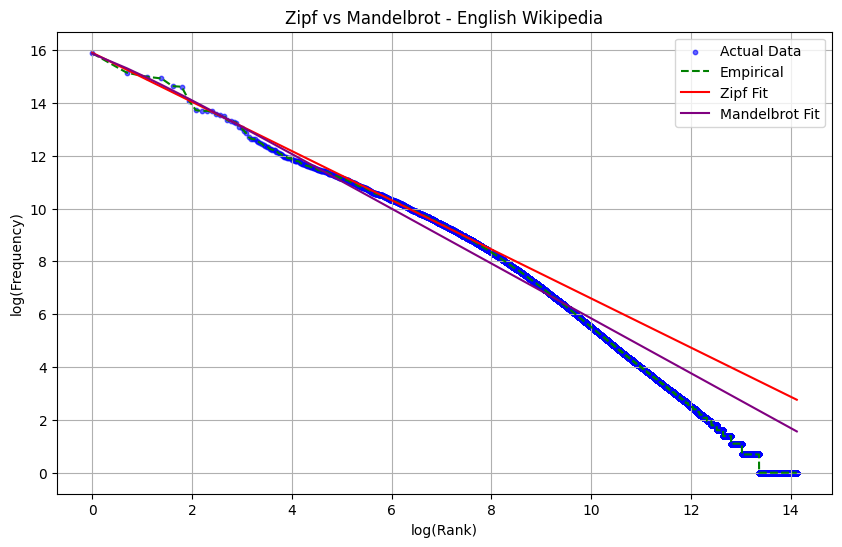

Top 50 words: ('the', 'of', 'in', 'and', 'a', 'to', 'was', 'for', 'on', 'as', 'is', 'by', 's', 'with', 'from', 'at', 'he', 'that', 'his', 'it', 'an', 'new', 'were', 'also', 'first', 'which', 'are', 'be', 'had', 'this', 'one', 'or', 'after', 'not', 'their', 'has', 'they', 'its', 'but', 'during', 'who', 'american', 'redirect', 'patriots', 'have', 'align', 'two', 'her', 'center', 'time')


In [ ]:
# Plot the rank-frequency distribution of English words on a log-log scale
results_en = plot_zipf_mandelbrot(word_counts_en, top_percent=0.05, title_suffix="English Wikipedia")

In [ ]:
# Zipf table
zipf_df = pd.DataFrame.from_dict(results_en["zipf_params"], orient='index', columns=['Value']).round(2)
zipf_df.index.name = 'Parameter'

# Mandelbrot table
mand_df = pd.DataFrame.from_dict(results_en["mandelbrot_params"], orient='index', columns=['Value']).round(2)
mand_df.index.name = 'Parameter'

# Combine
combined_df = pd.concat([zipf_df, mand_df], axis=1, keys=['Zipf', 'Mandelbrot'])

print("\nZipf and Mandelbrot Parameters for English:")
display(combined_df)



Zipf and Mandelbrot Parameters for English:


,Zipf,Mandelbrot
,Value,Value
Parameter,,
alpha,0.93,1.04
C,8009408.27,11134700.32
R2,0.98,0.99
RMSE,1235.94,1132.82
beta,NaN,0.42


### Discussion of English Zipf's & Mandelbrot Parameters

**1. Zipf's Parameters**  
- **Alpha (α = 0.93)**  
  Slightly below 1, indicating that while very common words dominate the corpus, lower-ranked words still appear more frequently than a perfect Zipf's distribution would suggest.  
- **Fit Quality (R² = 0.98, RMSE = 1235.94)**  
  The model captures the overall trend well. RMSE is moderate relative to total counts, showing a decent fit.The RMSE value is subjective to preprocessing choices and the corpus.

**2. Mandelbrot Parameters**  
- **Alpha (α = 1.04)**  
  Slightly above 1, implying a sharper drop for lower-ranked words.  
- **Beta (β = 0.42)**  
  Adjusts the very high-frequency words, preventing them from dominating the curve too sharply.  
- **Fit Quality (R² = 0.99, RMSE = 1132.82)**  
  Mandlebrot has better metrics compared to Zipf's suggesting it captured the behaviour of top-ranked words more accurately.

**3. Key Takeaways**  
- **Corpus structure:** English is heavy-tailed, a few words are extremely frequent, most are rare.  
- **Tail behavior:** Rare words in the tail can cause deviations, often due to tokenization techniques, proper nouns, or specialized terms.  
- **Model Fit:** Mandelbrot slightly outperforms Zipf's by penalizing the frequency of the highest-frequency words a bit, while Zipf's already provides a strong general fit.


In [ ]:
nltk.download('stopwords')

# English stopwords set
stop_words = set(stopwords.words('english'))

# Top 5% words from the corpus
top_words_en = results_en["top_words"]

# Count words in top 5% of the corpus that are also English stopwords
stopword_count = sum(1 for w in top_words_en if w.lower() in stop_words)
total_top_words = len(top_words_en)

print(f"Top {total_top_words} words, stopwords: {stopword_count}")
print(f"Percentage of top words that are stopwords:"
 f"{stopword_count/total_top_words*100:.2f}%"
 )


Top 68193 words, stopwords: 139
Percentage of top words that are stopwords:0.20%


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words = set(stopwords.words('english'))

# Total frequency of stopwords in top 5% words
stopword_freq = sum(word_counts_en[w] for w in results_en["top_words"] if w.lower() in stop_words)
total_freq_top_words = sum(word_counts_en[w] for w in results_en["top_words"])

print(
    f"Percentage of token occurrences of English stopwords in top 5% words of the corpus: "
    f"{stopword_freq / total_freq_top_words * 100:.2f}%"
)



Percentage of token occurrences of English stopwords in top 5% words of the corpus: 38.59%


### Top 5% Words and Stopwords in English

- The **top 5% of words** in the English Wikipedia corpus consists of 68,193 unique tokens.  
- Out of these, only **139 are stopwords**, which is **0.2%** of the top-ranked words.  
- Despite being such a small fraction, these stopwords account for **38.6% of all token occurrences** within the top 5%.  

**Interpretation:**  
- A small set of very frequent words (mostly stopwords like “the”, “and”, “of”) dominates the corpus.  
- Even though there are many unique words in the top 5%, the actual token counts are slightly concentrated on these few common words.  



In [ ]:
from IPython.display import display


def model_deviation(word_counts, zipf_params, mandelbrot_params, top_n=3):
    # Prepare rank-frequency data
    words, freqs = zip(*word_counts.most_common())
    ranks = np.arange(1, len(freqs) + 1)
    freqs = np.array(freqs, dtype=float)

    # Zipf prediction
    alpha_z, C_z = zipf_params["alpha"], zipf_params["C"]
    pred_z = C_z / (ranks ** alpha_z)

    # Mandelbrot prediction
    alpha_m, beta_m, C_m = mandelbrot_params["alpha"], mandelbrot_params["beta"], mandelbrot_params["C"]
    pred_m = C_m / ((ranks + beta_m) ** alpha_m)

    # Log-space deviation
    log_dev_zipf = np.abs(np.log(freqs) - np.log(pred_z))
    log_dev_mandelbrot = np.abs(np.log(freqs) - np.log(pred_m))

    # Identify top deviations in log-space
    top_zipf_idx = np.argsort(-log_dev_zipf)[:top_n]
    top_mandelbrot_idx = np.argsort(-log_dev_mandelbrot)[:top_n]



    # Create DataFrame for top Zipf deviations
    zipf_top_df = pd.DataFrame({
        'Word': [words[idx] for idx in top_zipf_idx],
        'Frequency': [freqs[idx] for idx in top_zipf_idx],
        'Predicted_Zipf': [pred_z[idx] for idx in top_zipf_idx],
        'Log_Deviation': [log_dev_zipf[idx] for idx in top_zipf_idx]
      }).round(2)

    # Create DataFrame for top Mandelbrot deviations
    mand_top_df = pd.DataFrame({
        'Word': [words[idx] for idx in top_mandelbrot_idx],
        'Frequency': [freqs[idx] for idx in top_mandelbrot_idx],
        'Predicted_Mandelbrot': [pred_m[idx] for idx in top_mandelbrot_idx],
        'Log_Deviation': [log_dev_mandelbrot[idx] for idx in top_mandelbrot_idx]
    }).round(2)

    # Prepare DataFrames without index
    zipf_top_df_no_idx = zipf_top_df.copy()
    zipf_top_df_no_idx.reset_index(drop=True, inplace=True)

    mand_top_df_no_idx = mand_top_df.copy()
    mand_top_df_no_idx.reset_index(drop=True, inplace=True)

    # Display results
    print("Top words deviating from Zipf fit:")
    display(zipf_top_df_no_idx)

    print("\nTop words deviating from Mandelbrot fit:")
    display(mand_top_df_no_idx)



    return {
        "zipf_log_dev": log_dev_zipf,
        "mandelbrot_log_dev": log_dev_mandelbrot
    }


In [ ]:
zipf_params = results_en["zipf_params"]
mandelbrot_params = results_en["mandelbrot_params"]
deviations = model_deviation(word_counts_en, zipf_params, mandelbrot_params)


Top words deviating from Zipf fit:


,Word,Frequency,Predicted_Zipf,Log_Deviation
0,mantegazzianus,1.0,32.04,3.47
1,ktxt-fm,1.0,32.04,3.47
2,ktxt-tv,1.0,32.04,3.47



Top words deviating from Mandelbrot fit:


,Word,Frequency,Predicted_Mandelbrot,Log_Deviation
0,mantegazzianus,1.0,10.48,2.35
1,ktxt-fm,1.0,10.48,2.35
2,ktxt-tv,1.0,10.48,2.35


### Top Deviating Word from Model Fits (English)

These are the words where the models underestimate/overestimate frequency the most compared to actual counts.


**Interpretation:**  
- The word `mantegazzianus` is rare but the models, especially Zipf's, overpredicts its frequency.  
- Mandelbrot reduces the deviation slightly due to the β adjustment, but rare words in the tail are still not perfectly captured.  
- Such deviations are observed for the rare occurring words, which are subjective to the corpus, tokenization errors and processing steps
- Some of the rare occurring words such as `ktxt-tv` also suggest tokenization errors which relies on the preprocessing pipeline


### Marathi (Native Language)

In [ ]:
cleaned_path = '/content/drive/MyDrive/NLP/mrwiki_corpus_cleaned.txt'
word_counts_mr = rebuild_word_counts(cleaned_path)

print("Top 20 words:", word_counts_mr.most_common(20))


Top 20 words: [('आणि', 261611), ('आहे', 260398), ('या', 149196), ('हे', 137596), ('व', 117352), ('एक', 101259), ('ते', 95852), ('हा', 88183), ('पुनर्निर्देशन', 77122), ('होते', 65846), ('आहेत', 64328), ('केले', 61309), ('ही', 59834), ('येथे', 58715), ('मध्ये', 54797), ('जिल्ह्यातील', 53862), ('तालुक्यातील', 49517), ('गावे', 49273), ('इस', 49190), ('केली', 48518)]


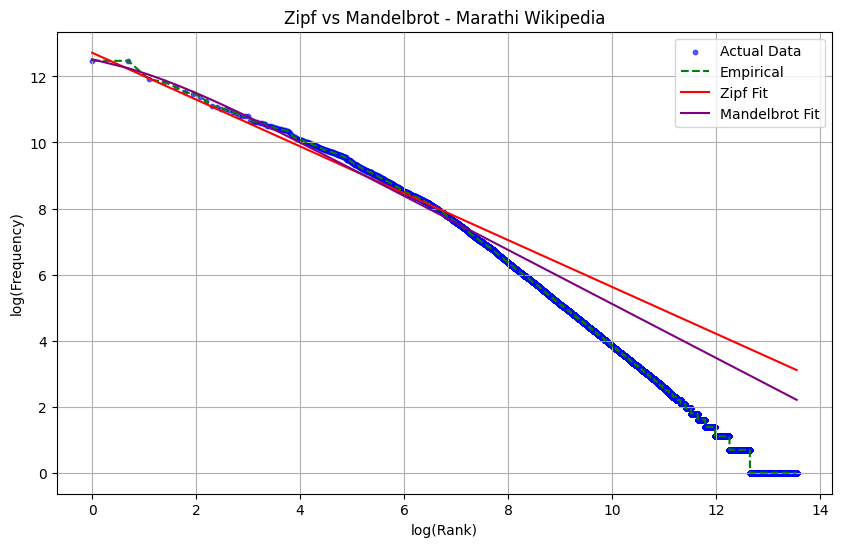

Top 50 words: ('आणि', 'आहे', 'या', 'हे', 'व', 'एक', 'ते', 'हा', 'पुनर्निर्देशन', 'होते', 'आहेत', 'केले', 'ही', 'येथे', 'मध्ये', 'जिल्ह्यातील', 'तालुक्यातील', 'गावे', 'इस', 'केली', 'भारतीय', 'तर', 'क्रिकेट', 'असते', 'म्हणून', 'भोपाळ', 'होता', 'अंतरावर', 'गंगू', 'असे', 'त्यांनी', 'होती', 'महाराष्ट्र', '१०', 'मधील', 'राजा', 'हवामान', 'जाते', 'तेली', 'किमी', 'गाव', 'राज्यातील', 'येथील', 'भोज', 'पर्यंत', 'असतो', 'झाली', 'झाले', 'यांनी', 'मराठी')


In [ ]:
# Results For Marathi
results_mr = plot_zipf_mandelbrot(word_counts_mr, title_suffix="Marathi Wikipedia")


In [ ]:
# Convert Zipf parameters to DataFrame
zipf_df = pd.DataFrame.from_dict(results_mr["zipf_params"], orient='index', columns=['Value']).round(3)
zipf_df.index.name = 'Parameter'

# Convert Mandelbrot parameters to DataFrame
mand_df = pd.DataFrame.from_dict(results_mr["mandelbrot_params"], orient='index', columns=['Value']).round(3)
mand_df.index.name = 'Parameter'

# Combine into one DataFrame
combined_df = pd.concat([zipf_df, mand_df], axis=1, keys=['Zipf', 'Mandelbrot'])

# Display
print("\nZipf and Mandelbrot Parameters for Marathi:")
display(combined_df)



Zipf and Mandelbrot Parameters for Marathi:


,Zipf,Mandelbrot
,Value,Value
Parameter,,
alpha,0.709,0.818
C,333305.785,591870.425
R2,0.949,0.980
RMSE,153.300,95.385
beta,NaN,1.571


### Marathi Zipf & Mandelbrot Parameters



**Discussion:**  
- **Zipf's α (0.709):** A shallow slope, indicating that while a few words are very frequent, lower-ranked words still have relatively higher frequencies than ideal Zipf's.Marathi’s heavy use of inflections mean that words appear in many forms, spreading their frequency across variations. Thus, we see a more balanced distribution here compared to languages with less inflections.
- **Mandelbrot α (0.818) & β (1.571):** β flattens the curve for very frequent words, and improves the fit at the top ranks. The slightly higher α compared to Zipf's shows a somewhat sharper drop for lower-ranked words.  
- **Fit quality:** R² and RMSE suggest both models fit well, with Mandelbrot slightly outperforming Zipf's.


In [ ]:
zipf_params_mr = results_mr["zipf_params"]
mandelbrot_params_mr = results_mr["mandelbrot_params"]
deviations = model_deviation(word_counts_mr, zipf_params_mr, mandelbrot_params_mr)


Top words deviating from Zipf fit:


,Word,Frequency,Predicted_Zipf,Log_Deviation
0,फटकाऱ्यांसरशी,1.0,42.39,3.75
1,निसर्गचित्र,1.0,42.39,3.75
2,शेतमळ्यांची,1.0,42.39,3.75



Top words deviating from Mandelbrot fit:


,Word,Frequency,Predicted_Mandelbrot,Log_Deviation
0,फटकाऱ्यांसरशी,1.0,18.98,2.94
1,निसर्गचित्र,1.0,18.98,2.94
2,शेतमळ्यांची,1.0,18.98,2.94


### Top Deviating Words from Model Fits (Marathi)

These are the words where the models **do not perfectly capture the observed frequency**, as observed they occur with rare frequency at the tail of the distribution



In [ ]:
from collections import defaultdict, Counter

#stanza.download('mr')
# Initialize Marathi pipeline
nlp = stanza.Pipeline('mr', processors='tokenize,mwt,pos,lemma')

# Get top 500 tokens by frequency
top_tokens = [token for token, _ in Counter(word_counts_mr).most_common(500)]

# Process batch
corpus_text = " ".join(top_tokens)
doc = nlp(corpus_text)

# Map lemma -> set of inflected forms
lemma_to_forms = defaultdict(set)
for sent in doc.sentences:
    for word in sent.words:
        lemma_to_forms[word.lemma].add(word.text)

# Show top lemmas by number of inflections
sorted_lemmas = sorted(lemma_to_forms.items(), key=lambda x: len(x[1]), reverse=True)

# Print top 10 lemmas by number of inflected forms
for lemma, forms in sorted_lemmas[:10]:
    print(f"{lemma}: {forms}")

# Average inflectional richness in top 500
avg_forms = sum(len(forms) for forms in lemma_to_forms.values()) / len(lemma_to_forms)
print("\nAverage inflectional richness (forms per lemma) in top 500 words:", avg_forms)


INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: mr (Marathi):
| Processor | Package       |
-----------------------------
| tokenize  | ufal          |
| mwt       | ufal          |
| pos       | ufal_charlm   |
| lemma     | ufal_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


असणे: {'असतो', 'आहेत', 'नाही', 'असून', 'होतो', 'आहे', 'असतात', 'होती', 'असलेले', 'असते', 'होता', 'असणाऱ्या', 'नव्हती', 'होते', 'नव्हता'}
तो: {'ते', 'त्यांना', 'त्याला', 'तिला', 'त्यांनी', 'तो', 'त्यां', 'तिने', 'त्याने', 'ती', 'तेली', 'ति', 'त्या'}
करणे: {'करतात', 'करण्यात', 'करते', 'करत', 'करणे', 'केली', 'केला', 'करण्या', 'करून', 'केले'}
जाणे: {'जाते', 'जातो', 'गेली', 'जातात', 'गेले', 'जाऊन', 'गेल्या', 'जात', 'गेला'}
येणे: {'येथील', 'आली', 'येते', 'आला', 'येतो', 'आले', 'येतात'}
हा: {'हा', 'यां', 'ह्या', 'हे', 'या', 'याला'}
होणे: {'झाले', 'होत', 'होत्या', 'झाला', 'होऊन', 'झाली'}
चा: {'चे', 'च्या', 'चा', 'ची'}
घेणे: {'घेतले', 'घेऊन', 'घेतला', 'घेतली'}
देणे: {'दिला', 'दिली', 'दिले', 'देण्यात'}

Average inflectional richness (forms per lemma) in top 500 words: 1.2469135802469136


### Impact of Inflectional Richness of Marathi
Many of the top 500 most frequent words in the Marathi corpus are actually different **inflected forms of the same lemma** rather than independent words. For example:  

- `असणे` appears as `असतो`, `आहेत`, `नाही`, `असलेले`, `होती`  
- `करणे` appears as `करतात`, `करते`, `करत`, `केली`, `केला`, `करून`
- `तो` appears as `ते`, `त्यांना`, `तिला`, `तो`, `तेली`, `ती`, etc.  

This shows that **inflectional richness significantly contributes to the high-frequency words**, inflating the counts of certain lemmas in the top ranks. These variations explain why some lemmas dominate the corpus and cause slight deviations from the ideal Zipf distribution.


In [ ]:
# Marathi stopwords
marathi_stopwords = stopwords.stopwords("mr")

# Top 5% Marathi words are that are stopwords
top_words = results_mr["top_words"]
stopwords_in_top_mr = [word for word in top_words if word in marathi_stopwords]

# Compute percentage
percentage_stopwords = (len(stopwords_in_top_mr) / len(top_words)) * 100

# Print results
print("Number of Marathi stopwords in top 5%:", len(stopwords_in_top_mr))
print("Percentage of top 5% words that are stopwords: {:.2f}%".format(percentage_stopwords))
print("Example Marathi stopwords in top 5%:", stopwords_in_top_mr[:20])


Number of Marathi stopwords in top 5%: 89
Percentage of top 5% words that are stopwords: 0.23%
Example Marathi stopwords in top 5%: ['आणि', 'आहे', 'या', 'हे', 'व', 'एक', 'ते', 'हा', 'होते', 'आहेत', 'केले', 'ही', 'येथे', 'केली', 'तर', 'म्हणून', 'होता', 'असे', 'होती', 'येथील']


The percentage of stopwords appearing in top 5% is **0.23%** for Marathi. Although the percentage seems to be lower these words are highly frequent, indicating they would be constituting considerable amount of tokens generated in the corpus. Also owing to the inflectional richness of Marathi we are overestimating the unique words which are different forms of the same words which can also explain a lower percentage of stop words in the top 5%.

### Hindi (Chosen Language)

In [11]:
# Compute word_counts for Hindi cleaned corpora
cleaned_path = '/content/drive/MyDrive/NLP/hiwiki_corpus_cleaned.txt'
word_counts_hi = rebuild_word_counts(cleaned_path)

print("Top 20 words:", word_counts_hi.most_common(20))


Top 20 words: [('के', 4123680), ('में', 3209362), ('है', 2720141), ('की', 1953031), ('और', 1670233), ('से', 1635961), ('को', 1400418), ('का', 1310373), ('हैं', 1237217), ('एक', 902108), ('पर', 680815), ('किया', 594569), ('रूप', 560489), ('ने', 545344), ('लिए', 526014), ('गया', 499609), ('भी', 489821), ('यह', 483245), ('कि', 440366), ('था', 427711)]


In [12]:
# Number of Hindi Tokens
print(sum(word_counts_hi.values()))

84771462


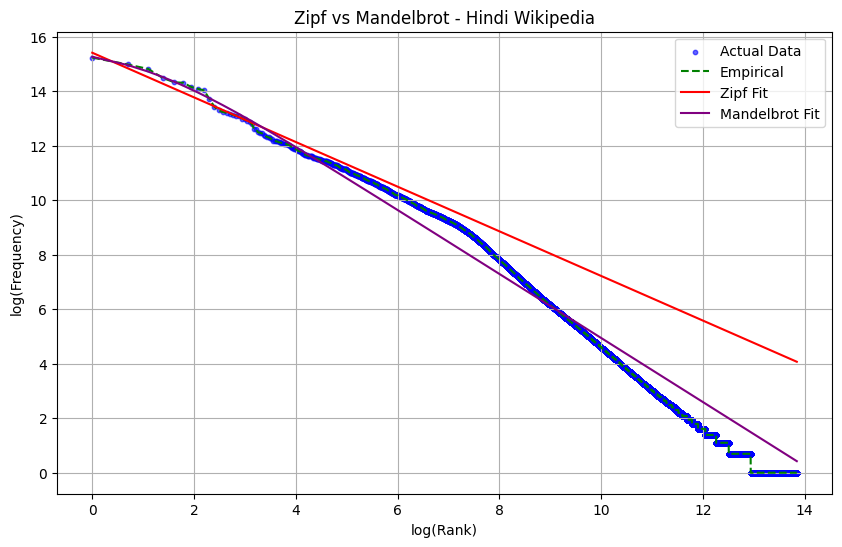

Top 50 words: ('के', 'में', 'है', 'की', 'और', 'से', 'को', 'का', 'हैं', 'एक', 'पर', 'किया', 'रूप', 'ने', 'लिए', 'गया', 'भी', 'यह', 'कि', 'था', 'इस', 'जाता', 'जो', 'तथा', 'हिप्पोकैम्पस', 'थे', 'द्वारा', 'ही', 'नहीं', 'साथ', 'करने', 'कुछ', 'दिया', 'या', 'उपहार', 'तक', 'हो', 'होता', 'कर', 'राज्य', 'बाद', 'थी', 'भारत', 'भारतीय', 'वह', 'वाले', 'जाने', 'अन्य', 'कई', 'हुआ')


In [15]:
# Plots for Hindi
results_hi = plot_zipf_mandelbrot(word_counts_hi, title_suffix="Hindi Wikipedia")

In [16]:
import pandas as pd

# Build DataFrame
combined_df_hi = pd.DataFrame({
    "Zipf": results_hi["zipf_params"],
    "Mandelbrot": results_hi["mandelbrot_params"]
})


combined_df_hi = combined_df_hi.round(3)

for col in combined_df_hi.columns:
    combined_df_hi[col] = combined_df_hi[col].apply(
        lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) and abs(x) > 1e5 else x
    )


combined_df_hi.index.name = "Parameter"

print("\nZipf and Mandelbrot Parameters for Hindi:")
display(combined_df_hi)



Zipf and Mandelbrot Parameters for Hindi:


,Zipf,Mandelbrot
Parameter,,
alpha,0.819,1.176
C,"4,932,382","17,931,247"
R2,0.949,0.991
RMSE,1661.34,717.013
beta,NaN,2.401


### Hindi Zipf's & Mandelbrot Parameters

**Discussion:**  
- **Zipf's α (0.819):** Less than 1, showing a shallow decay in word frequency. A few words are very common, but lower-ranked words still appear often. This reflects Hindi’s morphological richness, where words have many inflected forms.  
- **Mandelbrot α (1.176) & β (2.401):** β flattens the curve for the most frequent words, while α shows a sharper drop for mid-ranked words. This makes Mandelbrot fit the top-ranked words more accurately.  
- **Fit quality:** R² values of 0.949 (Zipf's) and 0.991 (Mandelbrot) show both models fit well, with Mandelbrot performing slightly better. RMSE also favors Mandelbrot (717 vs 1661), highlighting its flexibility.  

**Interpretation:** Hindi has a few very common words and many rare ones. Zipf's captures the general trend, while Mandelbrot adjusts for the most frequent words, providing a slightly better fit.


In [ ]:
zipf_params_hi = results_hi["zipf_params"]
mandelbrot_params_hi = results_hi["mandelbrot_params"]
deviations = model_deviation(word_counts_hi, zipf_params_hi, mandelbrot_params_hi)


Top words deviating from Zipf fit:


,Word,Frequency,Predicted_Zipf,Log_Deviation
0,काव्यावतरित,1.0,123.31,4.81
1,पञ्चोपचार,1.0,123.31,4.81
2,द्वात्रिंशोपचार,1.0,123.31,4.81



Top words deviating from Mandelbrot fit:


,Word,Frequency,Predicted_Mandelbrot,Log_Deviation
0,काव्यावतरित,1.0,4.44,1.49
1,पञ्चोपचार,1.0,4.44,1.49
2,द्वात्रिंशोपचार,1.0,4.44,1.49


### Top Deviating Words from Model Fits (Hindi)

These are the words where the models **do not perfectly capture the observed frequency**, as observed they occur with rare frequency at the tail of the distribution



In [ ]:
import stopwordsiso as stopwords

# Get Hindi stopwords
hindi_stopwords = stopwords.stopwords("hi")

# Check which top 5% Hindi words are stopwords
top_words_hi = results_hi["top_words"]  # replace with your Hindi top words list
stopwords_in_top_hi = [word for word in top_words_hi if word in hindi_stopwords]

# Compute percentage
percentage_stopwords_hi = (len(stopwords_in_top_hi) / len(top_words_hi)) * 100

# Print results
print("Number of Hindi stopwords in top 5%:", len(stopwords_in_top_hi))
print("Percentage of top 5% words that are stopwords: {:.2f}%".format(percentage_stopwords_hi))
print("Example Hindi stopwords in top 5%:", stopwords_in_top_hi[:20])


Number of Hindi stopwords in top 5%: 178
Percentage of top 5% words that are stopwords: 0.35%
Example Hindi stopwords in top 5%: ['के', 'में', 'है', 'की', 'और', 'से', 'को', 'का', 'हैं', 'एक', 'पर', 'किया', 'ने', 'लिए', 'गया', 'भी', 'यह', 'कि', 'था', 'इस']


The percentage of stopwords in the **top 5%** of Hindi words is **0.35%**. While this proportion seems low, these words are extremely frequent, meaning they still account for a significant fraction of the tokens in the corpus. Additionally, like Marathi, Hindi exhibits inflectional richness, so multiple forms of the same word might slightly underestimate their overall frequency.

-----

## Task 2 : Heaps' Law

This code reads a text corpus, tokenizes it, and tracks how the number of **unique words** (vocabulary) grows as more tokens are processed. It records the vocabulary size after every 10,000 tokens.  

**Heaps' Law** states that vocabulary size grows sublinearly with the total number of tokens:  
$$
V(N) = K \cdot N^\beta
$$
where $V(N)$ is the vocabulary size, $N$ is the total tokens, and $K, \beta$ are constants specific for the corpus.



In [ ]:
from collections import Counter
import numpy as np

# Calculate Vocabulary growth( after every 10000 tokens)
def calculate_vocab_growth(corpus_path, step=10000):
    vocab_set = set()
    vocab_sizes = []
    tokens_seen = []

    total_tokens = 0
    with open(corpus_path, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.strip().split()
            for token in tokens:
                vocab_set.add(token)
                total_tokens += 1

                if total_tokens % step == 0:
                    vocab_sizes.append(len(vocab_set))
                    tokens_seen.append(total_tokens)

    # If total_tokens isnt multiple of step
    if total_tokens % step != 0:
        vocab_sizes.append(len(vocab_set))
        tokens_seen.append(total_tokens)

    return np.array(tokens_seen), np.array(vocab_sizes),vocab_set


In [135]:
from scipy.optimize import curve_fit
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Heaps' Law
def heaps_law(N, K, beta):
    return K * N**beta

def fit_heaps_law(tokens_seen, vocab_sizes):
    # Fit the curve
    popt, _ = curve_fit(heaps_law, tokens_seen, vocab_sizes)
    K, beta = popt

    # Predict values using fitted parameters
    vocab_pred = heaps_law(tokens_seen, K, beta)

    # Compute R² and MSE
    r2 = r2_score(vocab_sizes, vocab_pred)
    mse = mean_squared_error(vocab_sizes, vocab_pred)

    return K, beta, r2, mse


In [ ]:
# plot the vocabulary with respect to number of tokens
def plot_vocab_growth(tokens_seen, vocab_sizes, K, beta, language):
    plt.figure(figsize=(8,5))
    plt.plot(tokens_seen, vocab_sizes, label='Empirical', color='blue')
    plt.plot(tokens_seen, heaps_law(tokens_seen, K, beta), label=f'Heaps law: K={K:.2f}, β={beta:.2f}', color='green', linestyle='--')
    plt.xlabel("Tokens (N)")
    plt.ylabel("Vocabulary size V(N)")
    plt.title(f"Vocabulary Growth - {language}")
    plt.legend()
    plt.grid(True)
    plt.show()


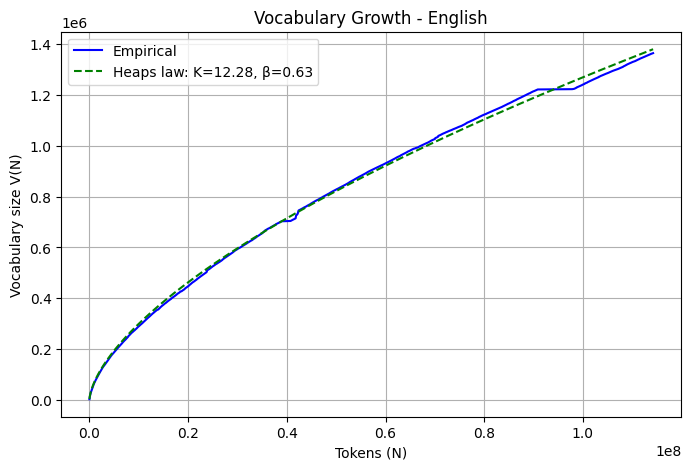

Estimated parameters for English: K = 12.28, β = 0.63
Fit metrics: R² = 0.998, MSE = 210865805.72


In [136]:
# Heaps' Law for English
corpus_path_en = '/content/drive/MyDrive/NLP/enwiki_corpus_cleanedv2.txt'
tokens_seen_en, vocab_sizes_en, vocab_set_en = calculate_vocab_growth(corpus_path_en, step=10000)

# Fit Heaps' Law and get R², RMSE
K_en, beta_en, r2_curve_en, mse_curve_en = fit_heaps_law(tokens_seen_en, vocab_sizes_en)

# Plot vocabulary growth
plot_vocab_growth(tokens_seen_en, vocab_sizes_en, K_en, beta_en, language="English")

# Print estimated parameters with fit metrics
print(f"Estimated parameters for English: K = {K_en:.2f}, β = {beta_en:.2f}")
print(f"Fit metrics: R² = {r2_curve_en:.3f}, MSE = {mse_curve_en:.2f}")


### Discussion
- **K=12.28**: This is the initial growth rate of vocabulary. For English it implies that at the very beginning, we see more unique words for few tokens.
- **β=0.63**: This suggests that although the vocabulary increases it increases at a slower rate as the corpus size increases. For English specifically, it indicates that as the corpus size increases although unique words appear, they appear less frequently

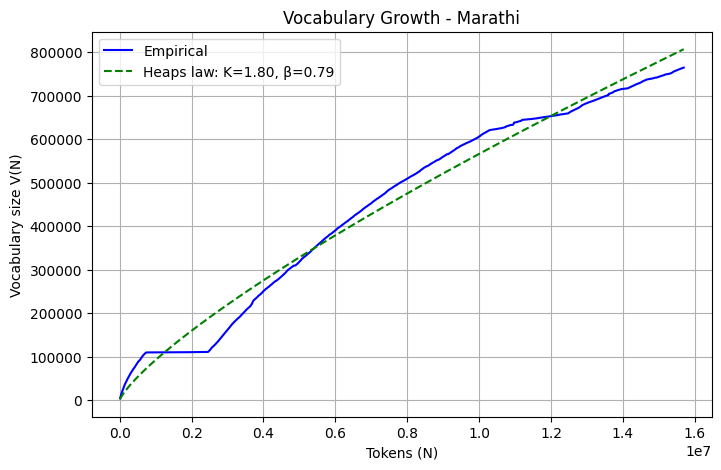

Estimated parameters for Marathi: K = 1.80, β = 0.79
Fit metrics: R² = 0.980, MSE = 1026075743.95


In [137]:
# Heaps' Law for Marathi
corpus_path_mr = '/content/drive/MyDrive/NLP/mrwiki_corpus_cleaned.txt'
tokens_seen_mr, vocab_sizes_mr, vocab_set_mr = calculate_vocab_growth(corpus_path_mr, step=10000)

# Fit Heaps' Law and get R², RMSE
K_mr, beta_mr, r2_curve_mr, mse_curve_mr = fit_heaps_law(tokens_seen_mr, vocab_sizes_mr)

# Plot vocabulary growth
plot_vocab_growth(tokens_seen_mr, vocab_sizes_mr, K_mr, beta_mr, language="Marathi")

# Print estimated parameters with fit metrics
print(f"Estimated parameters for Marathi: K = {K_mr:.2f}, β = {beta_mr:.2f}")
print(f"Fit metrics: R² = {r2_curve_mr:.3f}, MSE = {mse_curve_mr:.2f}")


### Discussion
- **K=1.80**: This is the initial growth rate of vocabulary. For Marathi it implies that at the very beginning, we see more unique words for few tokens. The initial growth rate is lesser as compared to English , the inflectional richness of Marathi could be the reason, as we might see the same words in different forms and include it as a unique word.
- **β=0.79**: This suggests that although the vocabulary increases it increases at a slower rate as the corpus size increases. Again, for Marathi the value is higher than that of English suggesting as the corpus grows we would find more unique words in Marathi as compared to English.

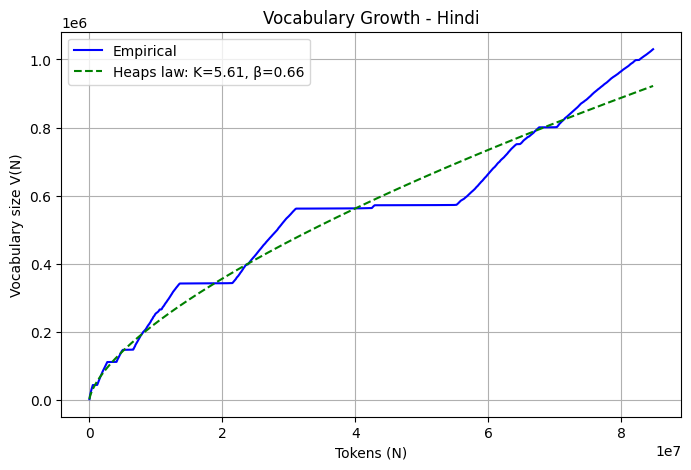

Estimated parameters for Hindi: K = 5.61, β = 0.66
Fit metrics: R² = 0.950, MSE = 2948102398.31


In [138]:
# Heaps' Law for Hindi
corpus_path_hi = '/content/drive/MyDrive/NLP/hiwiki_corpus_cleaned.txt'
tokens_seen_hi, vocab_sizes_hi, vocab_set_hi = calculate_vocab_growth(corpus_path_hi, step=10000)

# Fit Heaps' Law and get R², RMSE
K_hi, beta_hi, r2_curve_hi, mse_curve_hi = fit_heaps_law(tokens_seen_hi, vocab_sizes_hi)

# Plot vocabulary growth
plot_vocab_growth(tokens_seen_hi, vocab_sizes_hi, K_hi, beta_hi, language="Hindi")

# Print estimated parameters with fit metrics
print(f"Estimated parameters for Hindi: K = {K_hi:.2f}, β = {beta_hi:.2f}")
print(f"Fit metrics: R² = {r2_curve_hi:.3f}, MSE = {mse_curve_hi:.2f}")


### Discussion
- **K=5.61**: This is the initial growth rate of vocabulary. The value is higher compared to Marathi but lower compared to English. Both Hindi and Marathi possess inflectional richness, although the initial growth rate seems a little higher for Hindi compared to Marathi.
- **β=0.66**: This suggests that although the vocabulary increases it increases at a slower rate as the corpus size increases. For Hindi this value again lies between English and Marathi. Though the rate at which we see unique values decreases, we will find more unique values as corpus size increases in Hindi than in English.

In [139]:
data = {
    "Language": ["English", "Marathi", "Hindi"],
    "K": [K_en, K_mr, K_hi],
    "β": [beta_en, beta_mr, beta_hi],
    "Total Tokens": [tokens_seen_en[-1], tokens_seen_mr[-1], tokens_seen_hi[-1]],
    "Vocabulary Size": [vocab_sizes_en[-1], vocab_sizes_mr[-1], vocab_sizes_hi[-1]]
}

df = pd.DataFrame(data)

# Display the parameters
df.style.hide(axis="index").format({
            "K": "{:.2f}",
            "β": "{:.2f}",
            "Total Tokens": "{:,}",
            "Vocabulary Size": "{:,}"
        }).set_caption("Heaps' Law Parameters and Corpus Statistics")


Language,K,β,Total Tokens,Vocabulary Size
English,12.28,0.63,"114,216,313","1,363,872"
Marathi,1.80,0.79,"15,691,225","764,580"
Hindi,5.61,0.66,"84,771,462","1,029,903"


### Heaps' Law Summary

- **English (K=12.28, β=0.63)**: High initial growth rate, indicating many unique words appear early. As the corpus grows, new unique words appear more slowly.  

- **Marathi (K=1.80, β=0.79)**: Lower initial growth compared to English, likely due to **inflectional richness**, where the same lemma appears in multiple forms. The higher β suggests that as the corpus grows, more unique words continue to appear than in English.  

- **Hindi (K=5.61, β=0.66)**: Intermediate values between English and Marathi. Inflectional richness is present, but initial growth is higher than Marathi, and new unique words appear at a moderate rate as the corpus expands.


----

## Task 3: Computational Scaling – Vocabulary–Document Incidence Matrix

In [ ]:
from wiki_dump_reader import iterate

def count_documents(dump_path: str) -> int:
    page_count = 0
    for title, text in iterate(dump_path):
        page_count += 1
    return page_count



In [ ]:
num_docs_en = count_documents('/content/drive/MyDrive/NLP/enwiki_full.xml')
num_docs_mr = count_documents('/content/drive/MyDrive/NLP/mrwiki_full.xml')
num_docs_hi = count_documents('/content/drive/MyDrive/NLP/hiwiki_full.xml')

print("English docs:", num_docs_en)
print("Marathi docs:", num_docs_mr)
print("Hindi docs:", num_docs_hi)


English docs: 348043
Marathi docs: 182776
Hindi docs: 239358


### Memory Computation Formula

The memory required to store a vocabulary–document matrix is calculated as:

$$
\text{Memory (bytes)} = \text{Vocabulary Size} \times \text{Number of Documents} \times 8
$$

Here, each cell stores a 64-bit (8-byte) floating-point number. This formula directly gives the total memory in bytes needed to store the matrix.


In [ ]:
# Computer memory required by the vocabulary-document matrix
def compute_memory(vocab_size, num_docs, cell_size_bytes=8):
    # Formula to compute the estimated memory
    total_bytes = vocab_size * num_docs * cell_size_bytes

    # Using correct calculation
    if total_bytes < 10**3:
        return f"{total_bytes} Bytes"
    elif total_bytes < 10**6:
        return f"{total_bytes / 10**3:.2f} KB"
    elif total_bytes < 10**9:
        return f"{total_bytes / 10**6:.2f} MB"
    elif total_bytes < 10**12:
        return f"{total_bytes / 10**9:.2f} GB"
    else:
        return f"{total_bytes / 10**12:.2f} TB"


In [ ]:
# final vocab size from Task 2
vocab_sizes = {
    "English": vocab_sizes_en[-1],
    "Marathi": vocab_sizes_mr[-1],
    "Hindi": vocab_sizes_hi[-1]
}

num_docs = {
    "English": num_docs_en,
    "Marathi": num_docs_mr,
    "Hindi": num_docs_hi
}

memory={}

# Table Data
data = {
    "Language": [],
    "Vocabulary Size": [],
    "Number of Documents": [],
    "Estimated Memory": [],
    "Feasible on Local Machine": []
}

for lang in ["English", "Marathi", "Hindi"]:
    data["Language"].append(lang)
    data["Vocabulary Size"].append(f"{vocab_sizes[lang]:,}")
    data["Number of Documents"].append(f"{num_docs[lang]:,}")
    data["Estimated Memory"].append(compute_memory(vocab_sizes[lang], num_docs[lang]))
    data["Feasible on Local Machine"].append("No")  # new column
    memory[lang] = compute_memory(vocab_sizes[lang], num_docs[lang])

df_memory = pd.DataFrame(data)

# Display the results
df_memory.style.hide(axis="index").set_caption("Vocabulary-Document Matrix Memory Estimates")


Language,Vocabulary Size,Number of Documents,Estimated Memory,Feasible on Local Machine
English,"1,363,872","348,043",3.80 TB,No
Marathi,"764,580","182,776",1.12 TB,No
Hindi,"1,029,903","239,358",1.97 TB,No


From the Calculations, the memory required for storing the vocabulary–document matrix is in **TB's**, hence its **not feasible** to be stored on a local machine.

------

## Task 4 : Regression Fitting of Heaps’ Law

In [131]:
def heaps_regression(tokens_seen, vocab_sizes, language="Language"):
    # log-transform
    X = np.log(tokens_seen).reshape(-1, 1)
    y = np.log(vocab_sizes)

    # Fit linear regression
    reg = LinearRegression().fit(X, y)
    beta_reg = reg.coef_[0]          # slope
    K_reg = np.exp(reg.intercept_)   # anti log of parameter

    # Predicted values
    y_pred_log = reg.predict(X)
    y_pred = np.exp(y_pred_log)      # original scale

    # Measure of fit scores
    r2_log = r2_score(y, y_pred_log)
    mse_log = mean_squared_error(y, y_pred_log)

    mse = mean_squared_error(vocab_sizes, y_pred)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(np.log(tokens_seen), np.log(vocab_sizes), s=10, alpha=0.6, label='Empirical')
    plt.plot(np.log(tokens_seen), y_pred_log, color='red', label='Regression Fit')
    plt.xlabel('log(Tokens Seen)')
    plt.ylabel('log(Vocabulary Size)')
    plt.title(f"Heaps' Law Fit - {language}")
    plt.legend()
    plt.show()

    # Display results
    print(f"--- {language} ---")
    print(f"Regression-fitted K: {K_reg:.2f}, beta: {beta_reg:.2f}")
    print(f"R² (log-scale): {r2_log:.3f}")
    print(f"MSE (log-scale): {mse_log:.6f}")
    print(f"MSE (original scale): {mse:.2f}\n")

    return K_reg, beta_reg, r2_log, mse_log, mse


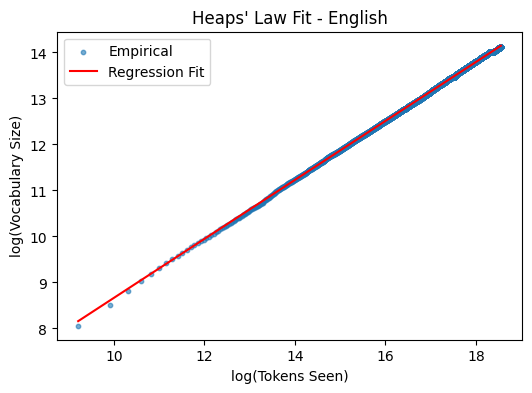

--- English ---
Regression-fitted K: 9.55, beta: 0.64
R² (log-scale): 0.999
MSE (log-scale): 0.000205
MSE (original scale): 247387429.42



In [140]:
# Heaps' regression for English
K_en_reg, beta_en_reg, r2_log_en, mse_log_en, mse_en = heaps_regression(tokens_seen_en, vocab_sizes_en, "English")


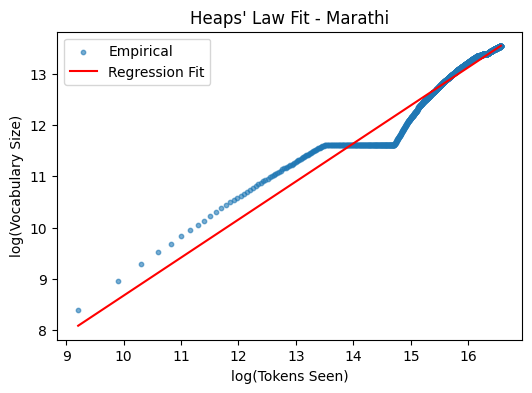

--- Marathi ---
Regression-fitted K: 3.46, beta: 0.74
R² (log-scale): 0.946
MSE (log-scale): 0.031030
MSE (original scale): 1384068284.08



In [141]:
# Heaps' regression for Marathi
K_mr_reg, beta_mr_reg, r2_log_mr, mse_log_mr, mse_mr = heaps_regression(tokens_seen_mr, vocab_sizes_mr, "Marathi")


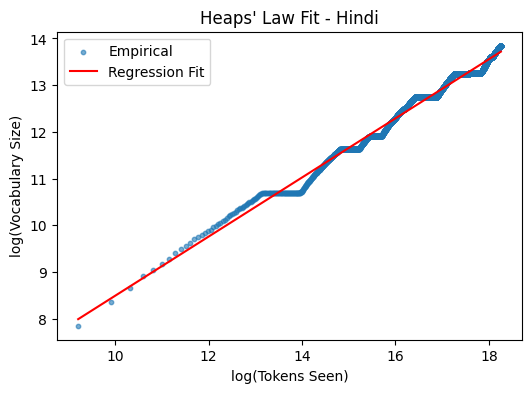

--- Hindi ---
Regression-fitted K: 8.62, beta: 0.63
R² (log-scale): 0.977
MSE (log-scale): 0.009187
MSE (original scale): 2997400595.44



In [142]:
# Heaps' regression for Hindi
K_hi_reg, beta_hi_reg, r2_log_hi, mse_log_hi, mse_hi = heaps_regression(tokens_seen_hi, vocab_sizes_hi, "Hindi")


In [147]:
import pandas as pd

languages = ["English", "Marathi", "Hindi"]

# Curve-fit parameters
K_curve = [K_en, K_mr, K_hi]
beta_curve = [beta_en, beta_mr, beta_hi]

# Regression-fitted parameters
K_reg = [K_en_reg, K_mr_reg, K_hi_reg]
beta_reg = [beta_en_reg, beta_mr_reg, beta_hi_reg]

# Regression metrics
R2_log_reg = [r2_log_en, r2_log_mr, r2_log_hi]        # log-scale R²
MSE_log_reg = [mse_log_en, mse_log_mr, mse_log_hi]  # log-scale MSE
MSE_reg = [mse_en, mse_mr, mse_hi]            # original-scale MSE

# Curve-fit metrics
R2_curve = [r2_curve_en, r2_curve_mr, r2_curve_hi]
MSE_curve = [mse_curve_en, mse_curve_mr, mse_curve_hi]

data = {
    "Language": languages,
    "Curve-Fit K": K_curve,
    "Curve-Fit β": beta_curve,
    "Curve-Fit R²": R2_curve,
    "Curve-Fit RMSE": MSE_curve,
    "Regression K": K_reg,
    "Regression β": beta_reg,
    "R² (log-scale)": R2_log_reg,
    "MSE (log-scale)": MSE_log_reg,
    "MSE (original-scale)": MSE_reg
}

df = pd.DataFrame(data)

# Display results
df.style.format({
    "Curve-Fit K": "{:.2f}",
    "Curve-Fit β": "{:.2f}",
    "Curve-Fit R²": "{:.3f}",
    "Curve-Fit MSE": "{:.2f}",
    "Regression K": "{:.2f}",
    "Regression β": "{:.2f}",
    "R² (log-scale)": "{:.3f}",
    "MSE (log-scale)": "{:.6f}",
    "MSE (original-scale)": "{:.2f}"
}).set_caption("Comparison of Heaps' Law Parameters: Curve Fit vs Regression")


,Language,Curve-Fit K,Curve-Fit β,Curve-Fit R²,Curve-Fit RMSE,Regression K,Regression β,R² (log-scale),MSE (log-scale),MSE (original-scale)
0,English,12.28,0.63,0.998,210865805.721572,9.55,0.64,0.999,0.000205,247387429.42
1,Marathi,1.80,0.79,0.980,1026075743.946514,3.46,0.74,0.946,0.031030,1384068284.08
2,Hindi,5.61,0.66,0.950,2948102398.311723,8.62,0.63,0.977,0.009187,2997400595.44


### Discussion

For the regression, we first fit Heaps' law on the **log-transformed data** (log(tokens_seen) vs log(vocab_sizes)). This gives us predictions in the log scale. To compare with the original data, we take the **anti-log (exponentiate) of these predictions** to bring them back to the original scale.

The **MSE on the original scale** is then computed between these anti-logged predictions and the actual vocabulary sizes. Because the exponential amplifies differences (particulary for large vocabulary sizes) this MSE ends up being **higher than the MSE from the curve-fit**, which was computed directly on the original counts without log transformation.

Despite the higher MSE, the R² values are still high, showing that regression on log-log scale captures the trend of vocabulary growth well.


## Task 5: Comparative Analysis and Report

### Summary

We worked on 3 corpora for our analysis

1. **English**
2. **Marathi**(Native Language)
3. **Hindi**(Chosen Language)

After completing preprocessing steps we get following results

In [148]:
import pandas as pd

# Tokens and vocab_size from Task 2
total_tokens = [tokens_seen_en[-1], tokens_seen_mr[-1], tokens_seen_hi[-1]]
vocab_sizes = [vocab_sizes_en[-1], vocab_sizes_mr[-1], vocab_sizes_hi[-1]]

data = {
    "Language": ["English", "Marathi", "Hindi"],
    "Total Tokens": total_tokens,
    "Vocabulary Size": vocab_sizes
}

df = pd.DataFrame(data)

# Display the table
df.style.hide(axis="index").format({
    "Total Tokens": "{:,}",
    "Vocabulary Size": "{:,}"
}).set_caption("Corpus Statistics: Total Tokens and Vocabulary Size")


Language,Total Tokens,Vocabulary Size
English,"114,216,313","1,363,872"
Marathi,"15,691,225","764,580"
Hindi,"84,771,462","1,029,903"


### Zipf's and Mandelbrot Analysis

| Language | Zipf α | Zipf C | Zipf R² | Zipf RMSE | Mandelbrot α | Mandelbrot β | Mandelbrot C | Mandelbrot R² | Mandelbrot RMSE |
|----------|--------|--------|---------|-----------|--------------|--------------|--------------|---------------|----------------|
| English  | 0.93   | 8009408.27 | 0.98   | 1235.94   | 1.04         | 0.42         | 11134700.32   | 0.99          | 1132.82        |
| Marathi  | 0.709   | 333305.785       | 0.949  | 153.300	     | 0.818         |  1.571       | 591870.425         |  0.980        | 95.385          |
| Hindi    | 0.819   | 4,932,382      | 0.949  | 1661.34      | 1.176         | 2.401         | 17,931,247         | 0.991         | 717.013          |



### Interpretation

Looking at the three languages, English has the steepest Zipf slope (α = 0.93), meaning a few words appear very often, while most words are rare. Marathi has the flattest slope (α = 0.71), so word frequencies are more evenly spread due to many word forms. Hindi is in between (α = 0.82), with a moderate spread of word frequencies.

The Mandelbrot model, with its extra β parameter, improves the fit for the most frequent words, especially in morphologically rich languages. English has a small β (0.42), so only a slight adjustment is needed. Marathi (β = 1.57) and Hindi (β = 2.40) require larger β values, which prevents the most common words from dominating and accounts for multiple word forms. As a result, RMSE is reduced significantly for Marathi and Hindi, showing Mandelbrot captures the frequency distribution more accurately across lower-frequency words.


### Zipf's plots

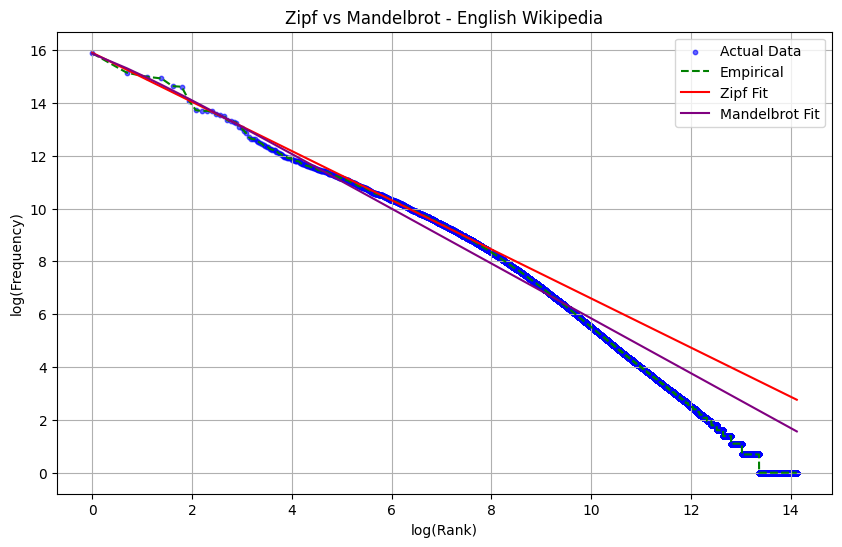

Top 50 words: ('the', 'of', 'in', 'and', 'a', 'to', 'was', 'for', 'on', 'as', 'is', 'by', 's', 'with', 'from', 'at', 'he', 'that', 'his', 'it', 'an', 'new', 'were', 'also', 'first', 'which', 'are', 'be', 'had', 'this', 'one', 'or', 'after', 'not', 'their', 'has', 'they', 'its', 'but', 'during', 'who', 'american', 'redirect', 'patriots', 'have', 'align', 'two', 'her', 'center', 'time')


In [149]:
import pandas as pd

# Plot the rank-frequency distribution of English words on a log-log scale
results_en = plot_zipf_mandelbrot(word_counts_en, top_percent=0.05, title_suffix="English Wikipedia")

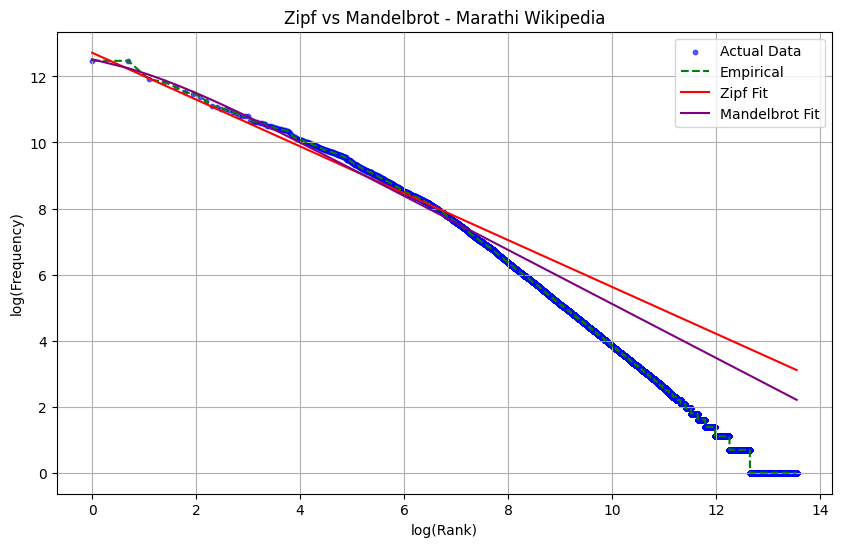

Top 50 words: ('आणि', 'आहे', 'या', 'हे', 'व', 'एक', 'ते', 'हा', 'पुनर्निर्देशन', 'होते', 'आहेत', 'केले', 'ही', 'येथे', 'मध्ये', 'जिल्ह्यातील', 'तालुक्यातील', 'गावे', 'इस', 'केली', 'भारतीय', 'तर', 'क्रिकेट', 'असते', 'म्हणून', 'भोपाळ', 'होता', 'अंतरावर', 'गंगू', 'असे', 'त्यांनी', 'होती', 'महाराष्ट्र', '१०', 'मधील', 'राजा', 'हवामान', 'जाते', 'तेली', 'किमी', 'गाव', 'राज्यातील', 'येथील', 'भोज', 'पर्यंत', 'असतो', 'झाली', 'झाले', 'यांनी', 'मराठी')


In [150]:
# Results For Marathi
results_mr = plot_zipf_mandelbrot(word_counts_mr, title_suffix="Marathi Wikipedia")


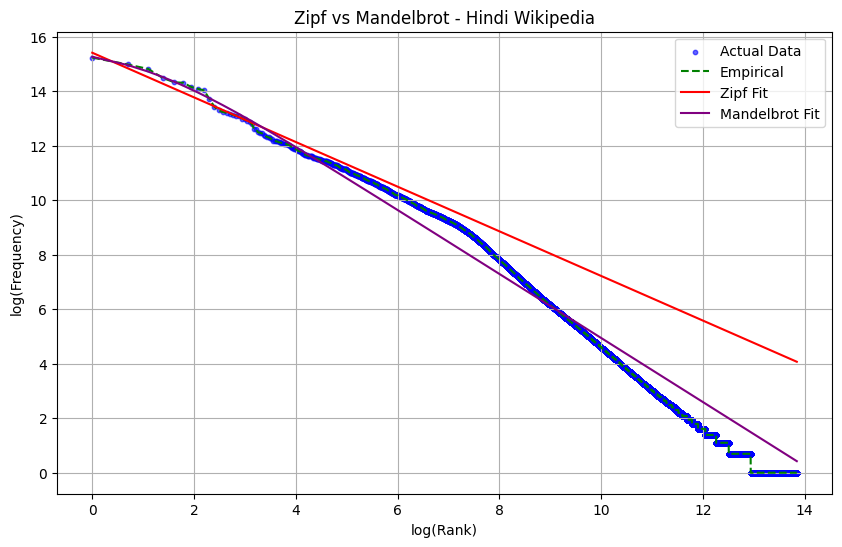

Top 50 words: ('के', 'में', 'है', 'की', 'और', 'से', 'को', 'का', 'हैं', 'एक', 'पर', 'किया', 'रूप', 'ने', 'लिए', 'गया', 'भी', 'यह', 'कि', 'था', 'इस', 'जाता', 'जो', 'तथा', 'हिप्पोकैम्पस', 'थे', 'द्वारा', 'ही', 'नहीं', 'साथ', 'करने', 'कुछ', 'दिया', 'या', 'उपहार', 'तक', 'हो', 'होता', 'कर', 'राज्य', 'बाद', 'थी', 'भारत', 'भारतीय', 'वह', 'वाले', 'जाने', 'अन्य', 'कई', 'हुआ')


In [151]:
# Results for Hindi
results_hi = plot_zipf_mandelbrot(word_counts_hi, title_suffix="Hindi Wikipedia")

### Discussion: Top Deviating Words from Model Fits

Across English, Marathi, and Hindi, the models generally capture the overall word frequency distribution well, but some rare words show **large relative deviations**—that is, the difference between predicted and actual frequency is large **relative to the predicted frequency**.

For example:  
- In English, `mantegazzianus` occurs only once, but Zipf’s model predicts ~32. This gives a high relative deviation even though the absolute difference (31) is small compared to the total token count. Mandelbrot reduces this slightly with its β adjustment, but rare words are still difficult to model precisely.  
- In Marathi, words like `फटकाऱ्यांसरशी`   occur once, yet the model predicts ~123.31, producing a very high relative deviation.  
- Similarly, in Hindi, `काव्यावतरित` appears once, while the model predicts ~42.39, again resulting in a large relative deviation.

These deviations usually happen at the tail of the distribution, where words appear very rarely. We use relative deviation instead of absolute deviation because it compares the error **proportionally** to the expected frequency, making it easier to see which words are truly mispredicted. This shows that while the models capture overall trends well, they are less accurate for very rare words. We also observe some anomalous words in the tail for example `ktxt-fm` and `ktxt-tv` which suggests some tokenization errors.



### Impact of Inflectional Richness in Marathi  

In Marathi, many of the top 500 most frequent tokens are just **different inflected forms of the same base word (lemma)** rather than unique words. For example, the lemma *“असणे”* appears as *असतो, आहेत, नाही, असलेले, होती*, and so on. Similarly, *“करणे”* spreads across *करतात, करते, केली, केला, करून*, etc.  

When we account for this, we find that each lemma in the top 500 words appears, on average, in about **1.25 different forms**. This means inflectional richness **inflates the frequency of certain lemmas**, making them appear disproportionately dominant at the top ranks and explaining why Marathi shows a shallower Zipf slope compared to English.  


### Heaps' Law

###### Heaps' Law Parameters and Corpus Statistics  

| Language | K    | β    | Total Tokens  | Vocabulary Size |
|----------|------|------|---------------|-----------------|
| English  | 12.28 | 0.63 | 114,216,313   | 1,363,872       |
| Marathi  | 1.80  | 0.79 | 15,691,225    | 764,580         |
| Hindi    | 5.61  | 0.66 | 84,771,462    | 1,029,903       |


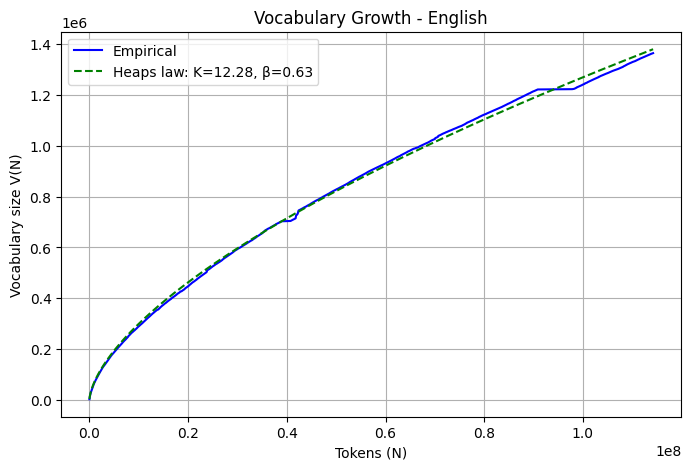

Estimated parameters for English: K = 12.28, β = 0.63
Fit metrics: R² = 0.998, MSE = 210865805.72


In [152]:
# Heaps' Law for English
corpus_path_en = '/content/drive/MyDrive/NLP/enwiki_corpus_cleanedv2.txt'
tokens_seen_en, vocab_sizes_en, vocab_set_en = calculate_vocab_growth(corpus_path_en, step=10000)

# Fit Heaps' Law and get R², RMSE
K_en, beta_en, r2_curve_en, mse_curve_en = fit_heaps_law(tokens_seen_en, vocab_sizes_en)

# Plot vocabulary growth
plot_vocab_growth(tokens_seen_en, vocab_sizes_en, K_en, beta_en, language="English")

# Print estimated parameters with fit metrics
print(f"Estimated parameters for English: K = {K_en:.2f}, β = {beta_en:.2f}")
print(f"Fit metrics: R² = {r2_curve_en:.3f}, MSE = {mse_curve_en:.2f}")


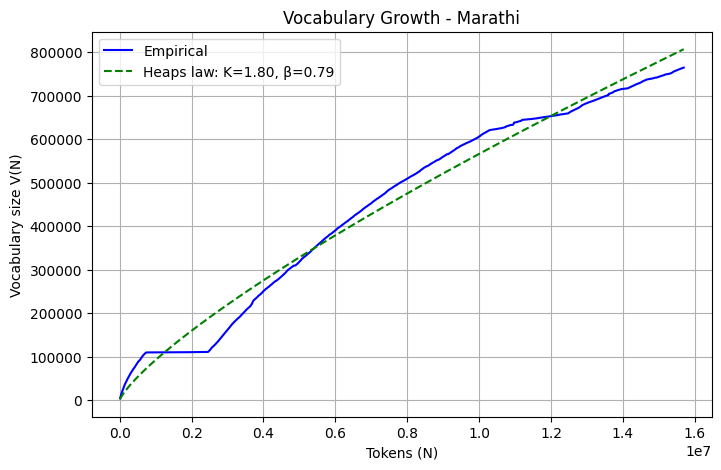

Estimated parameters for Marathi: K = 1.80, β = 0.79
Fit metrics: R² = 0.980, MSE = 1026075743.95


In [153]:
# Heaps' Law for Marathi
corpus_path_mr = '/content/drive/MyDrive/NLP/mrwiki_corpus_cleaned.txt'
tokens_seen_mr, vocab_sizes_mr, vocab_set_mr = calculate_vocab_growth(corpus_path_mr, step=10000)

# Fit Heaps' Law and get R², RMSE
K_mr, beta_mr, r2_curve_mr, mse_curve_mr = fit_heaps_law(tokens_seen_mr, vocab_sizes_mr)

# Plot vocabulary growth
plot_vocab_growth(tokens_seen_mr, vocab_sizes_mr, K_mr, beta_mr, language="Marathi")

# Print estimated parameters with fit metrics
print(f"Estimated parameters for Marathi: K = {K_mr:.2f}, β = {beta_mr:.2f}")
print(f"Fit metrics: R² = {r2_curve_mr:.3f}, MSE = {mse_curve_mr:.2f}")


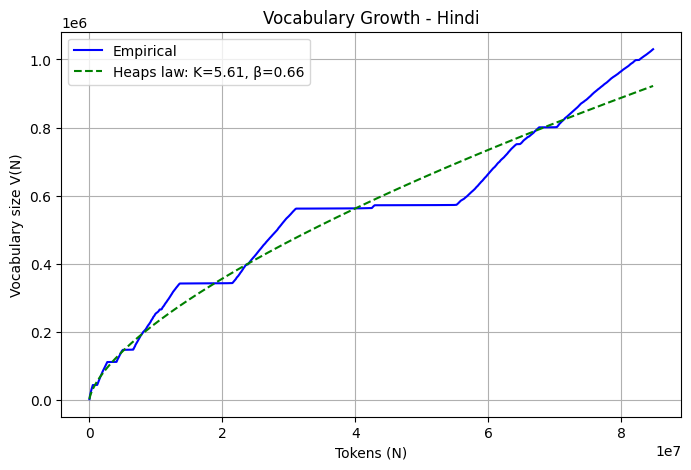

Estimated parameters for Hindi: K = 5.61, β = 0.66
Fit metrics: R² = 0.950, MSE = 2948102398.31


In [154]:
# Heaps' Law for Hindi
corpus_path_hi = '/content/drive/MyDrive/NLP/hiwiki_corpus_cleaned.txt'
tokens_seen_hi, vocab_sizes_hi, vocab_set_hi = calculate_vocab_growth(corpus_path_hi, step=10000)

# Fit Heaps' Law and get R², RMSE
K_hi, beta_hi, r2_curve_hi, mse_curve_hi = fit_heaps_law(tokens_seen_hi, vocab_sizes_hi)

# Plot vocabulary growth
plot_vocab_growth(tokens_seen_hi, vocab_sizes_hi, K_hi, beta_hi, language="Hindi")

# Print estimated parameters with fit metrics
print(f"Estimated parameters for Hindi: K = {K_hi:.2f}, β = {beta_hi:.2f}")
print(f"Fit metrics: R² = {r2_curve_hi:.3f}, MSE = {mse_curve_hi:.2f}")


### Heaps' Law Summary  

- **English (K=12.28, β=0.63):** Fast initial vocabulary growth, but new unique words slow down as the corpus grows.  
- **Marathi (K=1.80, β=0.79):** Slower start due to inflectional richness, but a higher β means more new words keep appearing with corpus size.  
- **Hindi (K=5.61, β=0.66):** Falls between English and Marathi—moderate initial growth and steady new word introduction.  


#### Linear Regression for Heaps' Law

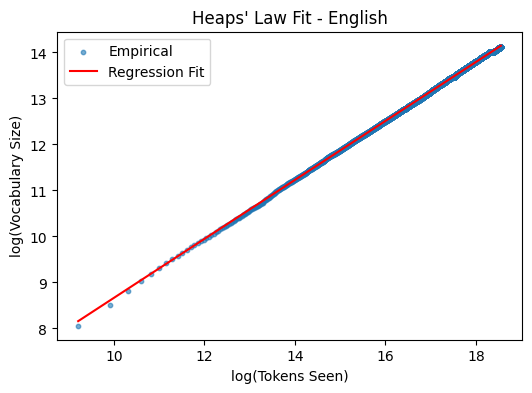

--- English ---
Regression-fitted K: 9.55, beta: 0.64
R² (log-scale): 0.999
MSE (log-scale): 0.000205
MSE (original scale): 247387429.42



In [155]:
# Heaps' regression for English
K_en_reg, beta_en_reg, r2_log_en, mse_log_en, mse_en = heaps_regression(tokens_seen_en, vocab_sizes_en, "English")


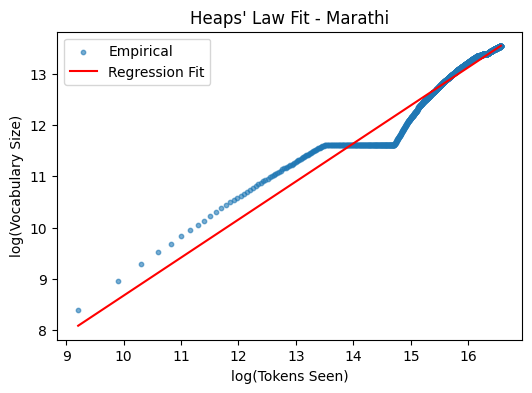

--- Marathi ---
Regression-fitted K: 3.46, beta: 0.74
R² (log-scale): 0.946
MSE (log-scale): 0.031030
MSE (original scale): 1384068284.08



In [156]:
# Heaps' regression for Marathi
K_mr_reg, beta_mr_reg, r2_log_mr, mse_log_mr, mse_mr = heaps_regression(tokens_seen_mr, vocab_sizes_mr, "Marathi")


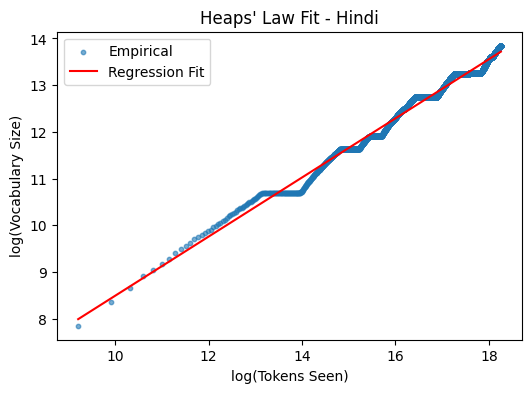

--- Hindi ---
Regression-fitted K: 8.62, beta: 0.63
R² (log-scale): 0.977
MSE (log-scale): 0.009187
MSE (original scale): 2997400595.44



In [157]:
# Heaps' regression for Hindi
K_hi_reg, beta_hi_reg, r2_log_hi, mse_log_hi, mse_hi = heaps_regression(tokens_seen_hi, vocab_sizes_hi, "Hindi")


### Comparison of Heaps' Law Parameters: Curve Fit vs Regression

| Language | Curve-Fit K | Curve-Fit β | Curve-Fit R² | Curve-Fit RMSE      | Regression K | Regression β | R² (log-scale) | MSE (log-scale) | MSE (original-scale) |
|----------|-------------|-------------|--------------|---------------------|--------------|--------------|----------------|-----------------|-----------------------|
| English  | 12.28       | 0.63        | 0.998        | 2.11 × 10⁸          | 9.55         | 0.64         | 0.999          | 0.000205        | 2.47 × 10⁸            |
| Marathi  | 1.80        | 0.79        | 0.980        | 1.03 × 10⁹          | 3.46         | 0.74         | 0.946          | 0.031030        | 1.38 × 10⁹            |
| Hindi    | 5.61        | 0.66        | 0.950        | 2.95 × 10⁹          | 8.62         | 0.63         | 0.977          | 0.009187        | 2.99 × 10⁹            |



### Interpretation
- **Fit Quality**: Curve fitting mostly yields higher **R²** values, showing a closer alignment with the empirical data, while regression on the log-scale performs a bit weaker in Marathi.  
- **Growth Parameters (K, β)**: Regression tends to estimate slightly lower β values (flattening vocabulary growth), especially for Marathi and Hindi. English remains stable across both methods.  
- **Error Metrics**: On the log-scale, regression achieves very low MSE, but when transformed back to the original scale, errors become larger—comparable or higher than curve fitting.  
- **Overall**: Curve-fit models appear more faithful for direct vocabulary prediction, while regression provides robustness and interpretability on the log-log scale.  


### Vocabulary–Document Matrix Memory Estimates

| Language | Vocabulary Size | Number of Documents | Estimated Memory | Feasible on Local Machine |
|----------|----------------|-------------------|-----------------|--------------------------|
| English  | 1,363,872      | 348,043           | 3.80 TB         | No                       |
| Marathi  | 764,580        | 182,776           | 1.12 TB         | No                       |
| Hindi    | 1,029,903      | 239,358           | 1.97 TB         | No                       |

The memory needed to store a full vocabulary–document matrix is huge for all three languages. For English, it would take nearly 4 TB, which is way beyond what a normal laptop or desktop can handle. Marathi and Hindi also need about 1-2 TB memory.
Even though most of the matrix is empty (most words don’t appear in most documents), the sheer number of words and documents makes it impractical to store on a local machine. We can thus use sparse matrices or specialized databases when working with big datasets.


## Final Summary

In this report, we looked at English, Marathi, and Hindi corpora using **Zipf’s Law, Mandelbrot models, Heaps’ Law, and vocabulary–document memory estimates**.

- **Zipf's & Mandelbrot:**  
  English shows the steepest Zipf's slope (α ≈ 0.93), meaning a small set of words dominates the text. Marathi (α ≈ 0.71) and Hindi (α ≈ 0.82) have flatter slopes because their words take many different forms—so frequency is more spread out. Mandelbrot’s β parameter helps model the very common words, which is especially useful in languages with lots of inflection.

- **Top Deviating Words:**  
  Rare words at the tail of the distribution show the largest **relative deviations**, even if the absolute differences are small. For example, `mantegazzianus` (English) and `फटकाऱ्यांसरशी` (Marathi) are mispredicted compared to the model. Looking at relative deviation shows which words the model struggles with proportionally.

- **Inflectional Richness (Marathi & Hindi):**  
  Many high-frequency words are actually different forms of the same lemma, inflating counts. In Marathi, the top 500 words have on average ~1.25 forms per lemma. This explains the shallower Zipf's slope and why vocabulary keeps growing steadily.

- **Heaps’ Law:**  
  English shows the fastest initial vocabulary growth (K ≈ 12.28), Marathi the slowest (K ≈ 1.80), and Hindi is in between (K ≈ 5.61). Morphologically rich languages like Marathi and Hindi keep producing new unique words as the corpus grows.

- **Vocabulary–Document Matrix Memory:**  
  Building full incidence matrices is not practical locally: English ~3.8 TB, Marathi ~1.1 TB, Hindi ~2.0 TB. Sparse or streaming approaches are necessary for working with large datasets.


Morphological complexity, inflectional richness, and corpus size all shape word frequency distributions, vocabulary growth, and computational requirements. English is dominated by a few common words, Marathi spreads frequency across many forms, and Hindi sits in between, showing both linguistic and practical differences.
